In [86]:
!nvidia-smi

Fri May  9 11:22:30 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   36C    P0             53W /  400W |    8663MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [87]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [88]:
! pip install torchinfo

In [89]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [90]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git
!ls pubmed-rct

fatal: destination path 'pubmed-rct' already exists and is not an empty directory.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [91]:
# Start by using the 20k dataset
data_dir = "pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [92]:
# Check all of the filenames in the target directory
import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt']

In [93]:
# Function to read all lines from a file
def get_lines(filename):
    with open(filename, "r") as f:
        return f.readlines()

In [94]:
# Creating a preprocessing function that returns a dictionary
def preprocess_text_with_line_numbers(filename):
  """Returns a list of dictionaries of abstract line data.

  Takes in filename, reads its contents and sorts through each line,
  extracting things like the target label, the text of the sentence,
  how many sentences are in the current abstract and what sentence number
  the target line is.

  Args:
      filename: a string of the target text file to read and extract line data
      from.

  Returns:
      A list of dictionaries each containing a line from an abstract,
      the lines label, the lines position in the abstract and the total number
      of lines in the abstract where the line is from. For example:

      [{"target": 'CONCLUSION',
        "text": The study couldn't have gone better, turns out people are kinder than you think",
        "line_number": 8,
        "total_lines": 8}]
  """
  input_lines = get_lines(filename) # get all lines from filename
  abstract_lines = "" # create an empty abstract
  abstract_samples = [] # create an empty list of abstracts

  # Loop through each line in target file
  for line in input_lines:
    if line.startswith("###"): # check to see if line is an ID line
      abstract_id = line
      abstract_lines = "" # reset abstract string
    elif line.isspace(): # check to see if line is a new line
      abstract_line_split = abstract_lines.splitlines() # split abstract into separate lines

      # Iterate through each line in abstract and count them at the same time
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} # create empty dict to store data from line
        target_text_split = abstract_line.split("\t") # split target label from text
        line_data["target"] = target_text_split[0] # get target label
        line_data["text"] = target_text_split[1].lower() # get target text and lower it
        line_data["line_number"] = abstract_line_number # what number line does the line appear in the abstract?
        line_data["total_lines"] = len(abstract_line_split) - 1 # how many total lines are in the abstract? (start from 0)
        abstract_samples.append(line_data) # add line data to abstract samples list

    else: # if the above conditions aren't fulfilled, the line contains a labelled sentence
      abstract_lines += line

  return abstract_samples

In [95]:
# Get data from file and preprocess it
%%time
train_samples = preprocess_text_with_line_numbers(data_dir + "train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir + "dev.txt")
test_samples = preprocess_text_with_line_numbers(data_dir + "test.txt")

len(train_samples), len(val_samples), len(test_samples)

CPU times: user 383 ms, sys: 92.3 ms, total: 475 ms
Wall time: 472 ms


(180040, 30212, 30135)

In [96]:
# Loading our data into a dataframe
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head(14)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [97]:
# Convert abstract text lines into lists
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()
len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [98]:
# One hot encoding the labels
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse_output=False)

train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1, 1))

# Check what training labels look like
train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [99]:
# Extract labels and encoder them into integers
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())

# Check what training labels look like
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [100]:
# Get class names and number of classes from LabelEncoder instance
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes , class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

In [101]:
# Getting the sentences and characters
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()

# Make function to split sentences into characters
def split_chars(text):
  return " ".join(list(text))

# Split sequence-level data splits into character-level data splits
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]

In [102]:
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()

In [103]:
# Generate position information: such as "2_of_7"
train_df["line_number_total"] = train_df["line_number"].astype(str) + "_of_" + train_df["total_lines"].astype(str)
val_df["line_number_total"] = val_df["line_number"].astype(str) + "_of_" + val_df["total_lines"].astype(str)
test_df["line_number_total"] = test_df["line_number"].astype(str) + "_of_" + test_df["total_lines"].astype(str)

In [104]:
import numpy as np

# OneHot 编码
one_hot_encoder = OneHotEncoder(sparse_output=False)
train_position_encoded = one_hot_encoder.fit_transform(np.array(train_df["line_number_total"]).reshape(-1, 1))
val_position_encoded = one_hot_encoder.transform(np.array(val_df["line_number_total"]).reshape(-1, 1))
test_position_encoded = one_hot_encoder.transform(np.array(test_df["line_number_total"]).reshape(-1, 1))

In [105]:
print("train_df columns:", train_df.columns.tolist())
print("val_df columns:", val_df.columns.tolist())
print("test_df columns:", test_df.columns.tolist())

train_df columns: ['target', 'text', 'line_number', 'total_lines', 'line_number_total']
val_df columns: ['target', 'text', 'line_number', 'total_lines', 'line_number_total']
test_df columns: ['target', 'text', 'line_number', 'total_lines', 'line_number_total']


# TokenBert Training

In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support
from tqdm.auto import tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import os

In [22]:
# === Config ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("✅ Using device:", device)
bert_model_name = "microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract"
BATCH_SIZE = 32
EPOCHS = 5
LR = 2e-5

✅ Using device: cuda


In [23]:
# === Tribrid Dataset ===
class TribridDataset(Dataset):
    def __init__(self, tokens, chars, positions, labels, tokenizer, max_len=128):
        self.tokens = tokens
        self.chars = chars
        self.positions = positions
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.tokens)

    def __getitem__(self, idx):
        token_text = self.tokens[idx]
        char_text = self.chars[idx]
        position_vec = torch.tensor(self.positions[idx], dtype=torch.float32)
        label = torch.tensor(self.labels[idx], dtype=torch.long)

        token_enc = self.tokenizer(token_text, padding='max_length', truncation=True, max_length=self.max_len, return_tensors="pt")
        char_enc = self.tokenizer(char_text, padding='max_length', truncation=True, max_length=self.max_len, return_tensors="pt")

        return {
            'input_ids_token': token_enc['input_ids'].squeeze(0),
            'attention_mask_token': token_enc['attention_mask'].squeeze(0),
            'input_ids_char': char_enc['input_ids'].squeeze(0),
            'attention_mask_char': char_enc['attention_mask'].squeeze(0),
            'position': position_vec,
            'label': label
        }

In [24]:
# === Tribrid Model ===
class TribridModel(nn.Module):
    def __init__(self, bert_name, position_dim, num_classes):
        super().__init__()
        self.bert_token = AutoModel.from_pretrained(bert_name)
        self.bert_char = AutoModel.from_pretrained(bert_name)

        self.token_dense = nn.Linear(self.bert_token.config.hidden_size, 64)
        self.char_dense = nn.Linear(self.bert_char.config.hidden_size, 64)
        self.position_dense = nn.Linear(position_dim, 32)

        self.dropout = nn.Dropout(0.5)
        self.classifier = nn.Sequential(
            nn.Linear(160, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, input_ids_token, attention_mask_token,
                input_ids_char, attention_mask_char,
                position):
        token_output = self.bert_token(input_ids_token, attention_mask=attention_mask_token).pooler_output
        char_output = self.bert_char(input_ids_char, attention_mask=attention_mask_char).pooler_output

        token_feat = torch.relu(self.token_dense(token_output))
        char_feat = torch.relu(self.char_dense(char_output))
        position_feat = torch.relu(self.position_dense(position))

        combined = torch.cat([token_feat, char_feat, position_feat], dim=1)
        combined = self.dropout(combined)
        return self.classifier(combined)

In [25]:
# === EarlyStopping ===
class EarlyStopping:
    def __init__(self, patience=3, min_delta=0.5):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None or val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

In [26]:
# === Training ===
def train_epoch(model, dataloader, optimizer, criterion):
    model.train()
    total_loss, correct, total = 0, 0, 0
    for batch in tqdm(dataloader, desc="Training"):
        for k in batch:
            batch[k] = batch[k].to(device)

        optimizer.zero_grad()
        outputs = model(batch['input_ids_token'], batch['attention_mask_token'],
                        batch['input_ids_char'], batch['attention_mask_char'], batch['position'])
        loss = criterion(outputs, batch['label'])
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = outputs.argmax(dim=1)
        correct += (preds == batch['label']).sum().item()
        total += batch['label'].size(0)

    return total_loss / len(dataloader), correct / total

In [27]:
def evaluate(model, dataloader, criterion):
    model.eval()
    total_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            for k in batch:
                batch[k] = batch[k].to(device)

            outputs = model(batch['input_ids_token'], batch['attention_mask_token'],
                            batch['input_ids_char'], batch['attention_mask_char'], batch['position'])
            loss = criterion(outputs, batch['label'])

            total_loss += loss.item()
            preds = outputs.argmax(dim=1)
            correct += (preds == batch['label']).sum().item()
            total += batch['label'].size(0)

    return total_loss / len(dataloader), correct / total

In [28]:
# === Prediction ===
def predict(model, dataloader):
    model.eval()
    all_preds, all_probs, all_labels = [], [], []
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Predicting"):
            for k in batch:
                batch[k] = batch[k].to(device)

            outputs = model(batch['input_ids_token'], batch['attention_mask_token'],
                            batch['input_ids_char'], batch['attention_mask_char'], batch['position'])
            probs = torch.softmax(outputs, dim=1)
            preds = torch.argmax(probs, dim=1)

            all_preds.append(preds.cpu())
            all_probs.append(probs.cpu())
            all_labels.append(batch['label'].cpu())

    return (
        torch.cat(all_preds).numpy(),
        torch.cat(all_probs).numpy(),
        torch.cat(all_labels).numpy()
    )

In [29]:
# === Metrics ===
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import itertools

def evaluate_classification(y_true, y_pred, class_names, figsize=(10, 8), text_size=14, norm=True):
    print("\n Classification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))

    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
    n_classes = cm.shape[0]

    fig, ax = plt.subplots(figsize=figsize)
    cax = ax.matshow(cm, cmap=plt.cm.Blues)
    fig.colorbar(cax)

    ax.set(title="Confusion Matrix",
           xlabel="Predicted label",
           ylabel="True label",
           xticks=np.arange(n_classes),
           yticks=np.arange(n_classes),
           xticklabels=class_names,
           yticklabels=class_names)

    ax.xaxis.set_label_position("bottom")
    ax.xaxis.tick_bottom()

    threshold = (cm.max() + cm.min()) / 2.
    for i, j in itertools.product(range(n_classes), range(n_classes)):
        value = cm[i, j]
        percent = cm_norm[i, j] * 100
        cell_text = f"{value}\n({percent:.1f}%)" if norm else f"{value}"
        ax.text(j, i, cell_text, ha="center", va="center",
                color="white" if value > threshold else "black", fontsize=text_size)

    plt.tight_layout()
    plt.show()

In [30]:
def calculate_results(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
    return {
        "accuracy": acc * 100,
        "precision": precision * 100,
        "recall": recall * 100,
        "f1": f1 * 100
    }

In [31]:
# === Ready for training and evaluation ===
from transformers import AutoTokenizer
from torch.utils.data import DataLoader

In [32]:
# Define tokenizer
tokenizer = AutoTokenizer.from_pretrained(bert_model_name)
position_dim = train_position_encoded.shape[1]

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/225k [00:00<?, ?B/s]

In [33]:
# Build datasets
train_dataset = TribridDataset(train_sentences, train_chars, train_position_encoded, train_labels_encoded, tokenizer)
val_dataset = TribridDataset(val_sentences, val_chars, val_position_encoded, val_labels_encoded, tokenizer)
test_dataset = TribridDataset(test_sentences, test_chars, test_position_encoded, test_labels_encoded, tokenizer)

In [34]:
# Build dataloaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [35]:
# === Model, optimizer, criterion ===
model = TribridModel(bert_model_name, position_dim, len(label_encoder.classes_)).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=2, min_lr=1e-7, verbose=True)
criterion = nn.CrossEntropyLoss()
early_stopper = EarlyStopping(patience=3, min_delta=0.5)

pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [36]:
best_val_loss = float('inf')
history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
os.makedirs("best_weights", exist_ok=True)

In [38]:
for epoch in range(EPOCHS):
    print(f"Epoch {epoch+1}/{EPOCHS}")

    train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion)
    val_loss, val_acc = evaluate(model, val_loader, criterion)
    print(f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    scheduler.step(val_loss)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_weights/checkpoint_tribrid.pt")
        print("✅ Saved best model!")

    early_stopper(val_loss)
    if early_stopper.early_stop:
        print("⏹️ Early stopping triggered!")
        break

    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)

Epoch 1/5


Training:   0%|          | 0/5627 [00:00<?, ?it/s]

KeyboardInterrupt: 

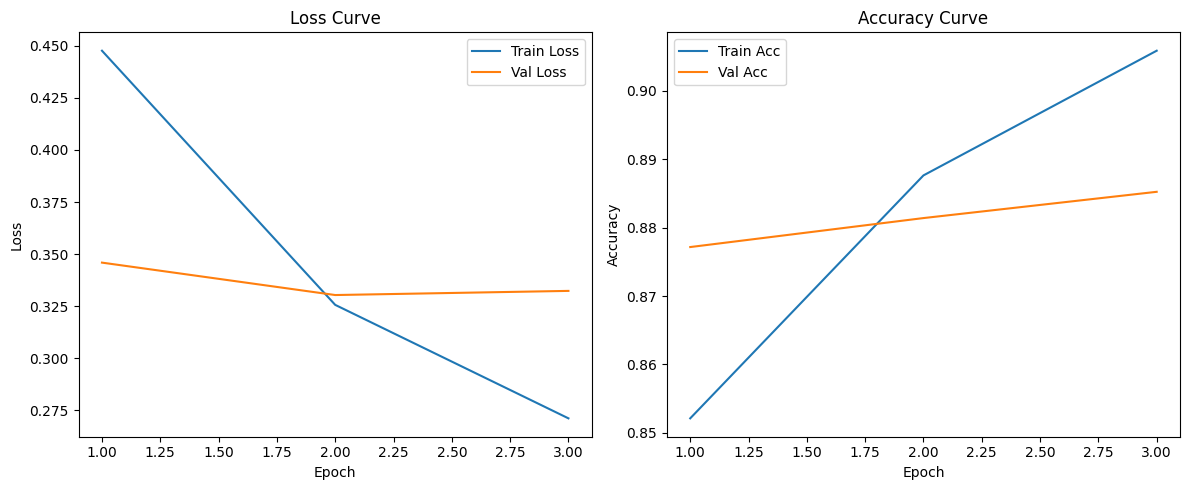

In [ ]:
# === Plot Training Curves ===
epochs_range = range(1, len(history["train_loss"])+1)
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(epochs_range, history["train_loss"], label='Train Loss')
plt.plot(epochs_range, history["val_loss"], label='Val Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs_range, history["train_acc"], label='Train Acc')
plt.plot(epochs_range, history["val_acc"], label='Val Acc')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy Curve")
plt.legend()
plt.tight_layout()
plt.show()

In [39]:
import shutil
import os

# 目标备份文件夹
backup_folder = '/content/drive/My Drive/ColabBackup'
os.makedirs(backup_folder, exist_ok=True)

# 复制模型权重文件
src = './best_weights/checkpoint_tribrid.pt'
dst = os.path.join(backup_folder, 'checkpoint_tribrid.pt')
shutil.copy(src, dst)

FileNotFoundError: [Errno 2] No such file or directory: './best_weights/checkpoint_tribrid.pt'

In [40]:
loaded_model = TribridModel(bert_model_name, position_dim, num_classes).to(device)
checkpoint_path = os.path.join(backup_folder, 'checkpoint_tribrid.pt')
loaded_model.load_state_dict(torch.load(checkpoint_path, map_location=device))
loaded_model.eval()

TribridModel(
  (bert_token): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elemen

In [41]:
from torchinfo import summary
# 构造 dummy 输入 (用于 summary 显示)
dummy_input = {
    'input_ids_token': torch.randint(0, 100, (1, 128)).to(device),
    'attention_mask_token': torch.ones(1, 128).to(device),
    'input_ids_char': torch.randint(0, 100, (1, 128)).to(device),
    'attention_mask_char': torch.ones(1, 128).to(device),
    'position': torch.randn(1, position_dim).to(device)
}

summary(loaded_model, input_data=dummy_input)

Layer (type:depth-idx)                                       Output Shape              Param #
TribridModel                                                 [1, 5]                    --
├─BertModel: 1-1                                             [1, 768]                  --
│    └─BertEmbeddings: 2-1                                   [1, 128, 768]             --
│    │    └─Embedding: 3-1                                   [1, 128, 768]             23,440,896
│    │    └─Embedding: 3-2                                   [1, 128, 768]             1,536
│    │    └─Embedding: 3-3                                   [1, 128, 768]             393,216
│    │    └─LayerNorm: 3-4                                   [1, 128, 768]             1,536
│    │    └─Dropout: 3-5                                     [1, 128, 768]             --
│    └─BertEncoder: 2-2                                      [1, 128, 768]             --
│    │    └─ModuleList: 3-6                                  --             

In [42]:
# === Final Evaluation ===
test_preds, test_probs, test_true = predict(loaded_model, test_loader)

Predicting:   0%|          | 0/942 [00:00<?, ?it/s]


 Classification Report:
              precision    recall  f1-score   support

  BACKGROUND       0.67      0.86      0.75      3621
 CONCLUSIONS       0.88      0.82      0.85      4571
     METHODS       0.93      0.96      0.94      9897
   OBJECTIVE       0.84      0.45      0.59      2333
     RESULTS       0.93      0.92      0.93      9713

    accuracy                           0.88     30135
   macro avg       0.85      0.80      0.81     30135
weighted avg       0.88      0.88      0.87     30135



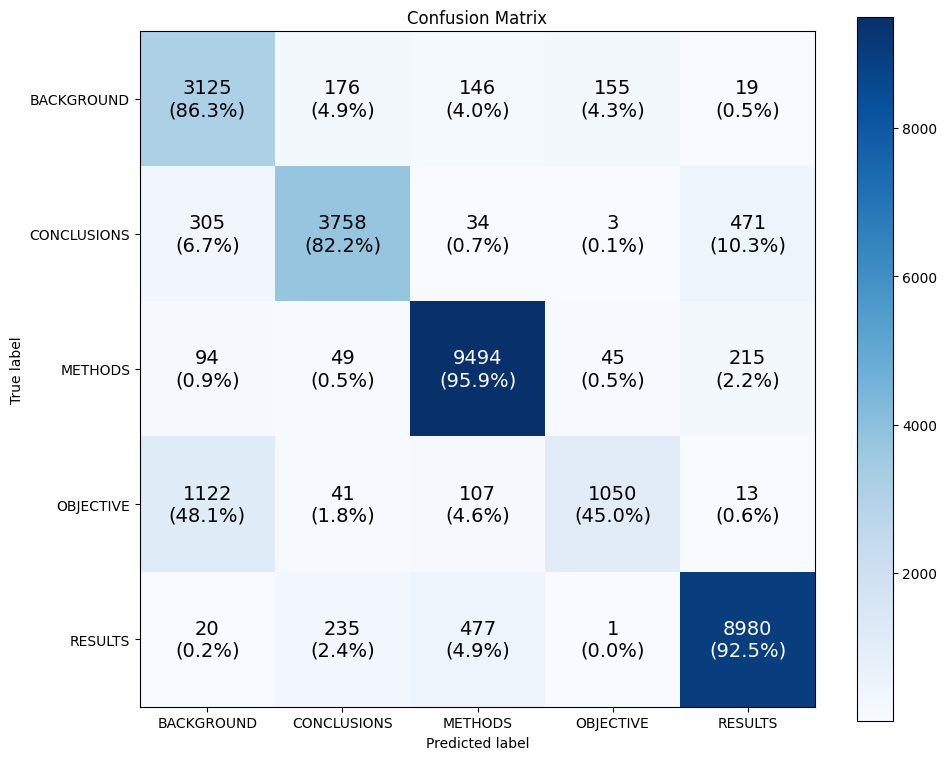

 Tribrid test performance:
{'accuracy': 87.62900282064045, 'precision': 88.15552262344536, 'recall': 87.62900282064045, 'f1': 87.26882010423664}


In [43]:
evaluate_classification(test_true, test_preds, class_names=label_encoder.classes_)
results = calculate_results(test_true, test_preds)
print(" Tribrid test performance:")
print(results)

In [44]:
results = calculate_results(y_true=test_labels_encoded,
                                    y_pred=test_preds)
results

{'accuracy': 87.62900282064045,
 'precision': 88.15552262344536,
 'recall': 87.62900282064045,
 'f1': 87.26882010423664}

In [106]:
test_df

,target,text,line_number,total_lines,line_number_total
0,BACKGROUND,this study analyzed liver function abnormaliti...,0,8,0_of_8
1,RESULTS,a post hoc analysis was conducted with the use...,1,8,1_of_8
2,RESULTS,liver function tests ( lfts ) were measured at...,2,8,2_of_8
3,RESULTS,survival analyses were used to assess the asso...,3,8,3_of_8
4,RESULTS,the percentage of patients with abnormal lfts ...,4,8,4_of_8
...,...,...,...,...,...
30130,RESULTS,there was a statistically significant between-...,13,17,13_of_17
30131,RESULTS,there were no statistically significant betwee...,14,17,14_of_17
30132,RESULTS,there was no significant association between s...,15,17,15_of_17
30133,RESULTS,no adverse effects were reported .,16,17,16_of_17


In [110]:
# === Enrich Test DataFrame with Prediction Info ===
test_pred_classes = [label_encoder.classes_[pred] for pred in test_preds]
test_df["prediction"] = test_pred_classes
test_df["pred_prob"] = np.max(test_probs, axis=1)  # max probability for each prediction
test_df["correct"] = test_df["prediction"] == test_df["target"]

# === Identify Top 100 Most Confident Wrong Predictions ===
top_100_wrong = test_df[test_df["correct"] == False].sort_values("pred_prob", ascending=False).head(100)

# === Display Top 10 for Review ===
for row in top_100_wrong.head(10).itertuples():
    print(f"Target: {row.target}, Pred: {row.prediction}, Prob: {row.pred_prob:.4f}, Line: {row.line_number} / {row.total_lines}")
    print(f"Text:\n{row.text}\n")
    print("-----")

Target: METHODS, Pred: RESULTS, Prob: 0.9980, Line: 16 / 19
Text:
( @ ) in the mia group and ada group , after surgery , the increased dosage of fentanyl citrate was less than that in the general anesthesia group -lsb- ( @ ) g/kg vs ( @ g/kg , ( @ g/kg vs ( @ g/kg , both p < @ -rsb- , reducing by @ % in comparison .

-----
Target: METHODS, Pred: RESULTS, Prob: 0.9980, Line: 9 / 12
Text:
in the saffron group , there was no decline in maximum isometric and isotonic forces after eccentric exercise , but a significant decline in the isometric force was observed in the control group ( p < @ ) .

-----
Target: CONCLUSIONS, Pred: RESULTS, Prob: 0.9979, Line: 6 / 11
Text:
rifampicin significantly increased the mean area under the plasma concentration-time curve ( auc ) of ( r ) - and ( s ) - fexofenadine ( @-fold and @-fold , respectively ) and decreased the renal clearance of ( r ) - and ( s ) - fexofenadine ( @-fold and @-fold , respectively ) , causing marked differences in the mean amounts

In [47]:
# Assuming test_df is enriched and top_100_wrong is defined
top_10_wrong = top_100_wrong.head(10).copy()

# Create a DataFrame for reporting
report_df = pd.DataFrame({
    "True Label": top_10_wrong["target"],
    "Predicted Label": top_10_wrong["prediction"],
    "Confidence": top_10_wrong["pred_prob"].round(4),
    "Line Position": top_10_wrong["line_number"].astype(str) + " / " + top_10_wrong["total_lines"].astype(str),
    "Sentence": top_10_wrong["text"]
})

# Display the top 10 misclassified samples
print(report_df.to_string(index=False))

# Optional: Save to CSV for inclusion in report or appendix
report_df.to_csv("top_10_misclassified.csv", index=False)



 True Label Predicted Label  Confidence Line Position                                                                                                                                                                                                                                                                                                                                                                                                                 Sentence
    METHODS         RESULTS      0.9980       16 / 19                                                                                                                                                              ( @ ) in the mia group and ada group , after surgery , the increased dosage of fentanyl citrate was less than that in the general anesthesia group -lsb- ( @ ) g/kg vs ( @ g/kg , ( @ g/kg vs ( @ g/kg , both p < @ -rsb- , reducing by @ % in comparison .
    METHODS         RESULTS      0.9980        9 / 12                     

In [107]:
test_df

,target,text,line_number,total_lines,line_number_total
0,BACKGROUND,this study analyzed liver function abnormaliti...,0,8,0_of_8
1,RESULTS,a post hoc analysis was conducted with the use...,1,8,1_of_8
2,RESULTS,liver function tests ( lfts ) were measured at...,2,8,2_of_8
3,RESULTS,survival analyses were used to assess the asso...,3,8,3_of_8
4,RESULTS,the percentage of patients with abnormal lfts ...,4,8,4_of_8
...,...,...,...,...,...
30130,RESULTS,there was a statistically significant between-...,13,17,13_of_17
30131,RESULTS,there were no statistically significant betwee...,14,17,14_of_17
30132,RESULTS,there was no significant association between s...,15,17,15_of_17
30133,RESULTS,no adverse effects were reported .,16,17,16_of_17


In [112]:
# 查看测试集中每个真实标签（target）的数量
test_df["target"].value_counts()

,count
target,
METHODS,9897
RESULTS,9713
CONCLUSIONS,4571
BACKGROUND,3621
OBJECTIVE,2333


In [117]:
objective_examples = test_df[test_df["target"] == "OBJECTIVE"]
objective_examples.head(5)  # 显示前5条

,target,text,line_number,total_lines,line_number_total,prediction,pred_prob,correct
44,OBJECTIVE,depressive disorders are one of the leading co...,0,13,0_of_13,BACKGROUND,0.925637,False
45,OBJECTIVE,numerous studies have demonstrated that pharma...,1,13,1_of_13,BACKGROUND,0.895209,False
46,OBJECTIVE,psycho-education as an intervention has been s...,2,13,2_of_13,BACKGROUND,0.897414,False
47,OBJECTIVE,the present study aimed to assess the impact o...,3,13,3_of_13,BACKGROUND,0.747214,False
58,OBJECTIVE,a pharmacokinetic substudy was conducted withi...,0,10,0_of_10,METHODS,0.423577,False


In [119]:
background_examples = test_df[test_df["target"] == "BACKGROUND"]
background_examples.head(5)  # 显示前5条


,target,text,line_number,total_lines,line_number_total,prediction,pred_prob,correct
0,BACKGROUND,this study analyzed liver function abnormaliti...,0,8,0_of_8,BACKGROUND,0.550146,True
9,BACKGROUND,minimally invasive endovascular aneurysm repai...,0,12,0_of_12,BACKGROUND,0.789165,True
10,BACKGROUND,the aim of this study was to analyse the cost-...,1,12,1_of_12,BACKGROUND,0.730652,True
22,BACKGROUND,evidence suggests that individuals with social...,0,8,0_of_8,BACKGROUND,0.887038,True
31,BACKGROUND,exposure to diesel exhaust causes inflammatory...,0,12,0_of_12,BACKGROUND,0.822197,True


In [116]:
# === Filter predictions where OBJECTIVE was misclassified as BACKGROUND ===
obj_to_back_errors = test_df[
    (test_df["target"] == "OBJECTIVE") &
    (test_df["prediction"] == "BACKGROUND") &
    (test_df["correct"] == False)
]

# === Sort these by prediction confidence (descending) ===
top_obj_to_back = obj_to_back_errors.sort_values("pred_prob", ascending=False).head(10)

# === Format into a report-ready DataFrame ===
error_examples = []
for i, row in enumerate(top_obj_to_back.itertuples(), 1):
    error_examples.append({
        "Index": i,
        "Confidence": f"{row.pred_prob:.4f}",
        "Line Position": f"{row.line_number} / {row.total_lines}",
        "Sentence Text": row.text.strip()
    })

# Create the final DataFrame
obj_to_back_report_df = pd.DataFrame(error_examples)

# Optional: Export or display
# obj_to_back_report_df.to_markdown(index=False)
# obj_to_back_report_df.to_latex(index=False)
# obj_to_back_report_df.to_csv("obj_to_back_errors.csv", index=False)

# Display for preview
obj_to_back_report_df



,Index,Confidence,Line Position,Sentence Text
0,1,0.9407,0 / 15,unhealthy alcohol use is a leading contributor...
1,2,0.9376,0 / 10,"optimal physical behaviour is important , as p..."
2,3,0.9340,0 / 10,uptake of human papillomavirus ( hpv ) vaccina...
3,4,0.9331,0 / 14,anemia affects most pregnant african women and...
4,5,0.9326,0 / 12,child pedestrian injury is a global public hea...
5,6,0.9256,0 / 13,depressive disorders are one of the leading co...
6,7,0.9244,0 / 11,mass drug administration ( mda ) is part of th...
7,8,0.9232,0 / 11,the gold standard in acl reconstructions has b...
8,9,0.9213,1 / 13,we evaluated the effectiveness of electronical...
9,10,0.9187,0 / 9,"access , enrollment , and engagement with prim..."
